In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from sklearn import cross_validation
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve

import warnings 
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("train.csv") 
data = data.replace(-999999,2)

X = data.iloc[:,:-1]
y = data.TARGET

In [5]:
features = ['var15'
,'var38'
,'saldo_var30'
,'saldo_medio_var5_hace2'
,'saldo_var37'
,'num_var45_ult3'
,'saldo_medio_var5_hace3'
,'num_var22_hace3'
,'num_var22_ult1'
,'imp_trans_var37_ult1'
,'num_meses_var39_vig_ult3'
,'saldo_medio_var5_ult3'
,'imp_ent_var16_ult1'
,'saldo_medio_var5_ult1'
,'imp_var43_emit_ult1'
,'num_var22_ult3'
,'num_var45_hace3'
,'num_var45_hace2'
,'saldo_medio_var12_hace2'
,'num_var45_ult1'
,'saldo_var31'
,'saldo_medio_var12_ult3'
,'imp_op_var41_comer_ult3'
,'imp_op_var39_efect_ult1'
,'imp_op_var39_ult1'
,'imp_op_var41_efect_ult1'
,'num_var37'
,'num_var43_recib_ult1'
,'num_op_var41_hace2'
,'num_ent_var16_ult1']

X = X[features]


In [6]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

X_normalized = normalize(X, axis=0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)
X['PCA1'] = X_pca[:,0]
X['PCA2'] = X_pca[:,1]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.sum(), y_test.sum(), y_val.sum())

(48652, 32) (15204, 32) (12164, 32)
1909 603 496


In [11]:
ratio = float(np.sum(y == 1)) / np.sum(y==0)

clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 5,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=1301)
                
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc", eval_set=[(X_train, y_train), (X_val, y_val)])
        
print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(X_train, ntree_limit=clf.best_iteration)[:,1]))

[0]	validation_0-auc:0.5	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.5	validation_1-auc:0.5
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.5	validation_1-auc:0.5
[8]	validation_0-auc:0.5	validation_1-auc:0.5
[9]	validation_0-auc:0.5	validation_1-auc:0.5
[10]	validation_0-auc:0.5	validation_1-auc:0.5
[11]	validation_0-auc:0.5	validation_1-auc:0.5
[12]	validation_0-auc:0.5	validation_1-auc:0.5
[13]	validation_0-auc:0.5	validation_1-auc:0.5
[14]	validation_0-auc:0.5	validation_1-auc:0.5
[15]	validation_0-auc:0.5	validation_1-auc:0.5
[16]	validation_0-auc:0.5	validation_1-auc:0.5
[17]	validation_0-auc:0.5	validation_1-auc:0.5
[18]	va

[145]	validation_0-auc:0.854042	validation_1-auc:0.838545
[146]	validation_0-auc:0.854134	validation_1-auc:0.838606
[147]	validation_0-auc:0.854383	validation_1-auc:0.838659
[148]	validation_0-auc:0.854483	validation_1-auc:0.838694
[149]	validation_0-auc:0.854685	validation_1-auc:0.838479
[150]	validation_0-auc:0.85477	validation_1-auc:0.838473
[151]	validation_0-auc:0.854879	validation_1-auc:0.838402
[152]	validation_0-auc:0.85498	validation_1-auc:0.838541
[153]	validation_0-auc:0.855085	validation_1-auc:0.838529
[154]	validation_0-auc:0.855149	validation_1-auc:0.838523
[155]	validation_0-auc:0.855235	validation_1-auc:0.838576
[156]	validation_0-auc:0.855329	validation_1-auc:0.838476
[157]	validation_0-auc:0.855397	validation_1-auc:0.838653
[158]	validation_0-auc:0.855516	validation_1-auc:0.838688
[159]	validation_0-auc:0.855567	validation_1-auc:0.838636
[160]	validation_0-auc:0.85562	validation_1-auc:0.83871
[161]	validation_0-auc:0.855672	validation_1-auc:0.838674
[162]	validation_0

Roc AUC: 0.8318926905095098


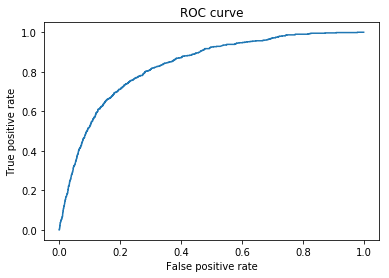

In [12]:
y_proba = clf.predict_proba(X_test)[:,1]
print("Roc AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro'))
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot(1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

model = xgb.XGBClassifier()
n_estimators = range(50, 200, 50)

param_grid = dict(n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=4, cv=kfold)
grid_result = grid_search.fit(X_test, y_test)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4,
                                   cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

# Here we go
random_search.fit(X_train, y_train)
